# TRAM
This example shows how the transition-based reweighting analysis method (TRAM) <cite data-footcite="wu2016multiensemble">(Wu et al, 2016)</cite> can be used to estimate a Markov state model of a simple double-well potential.

## Introduction

In the TRAM problem, we have a system which is governed by some unknown equilibrium distribution, $\mu(x) = e^{f - u(x)}$, where $u(x)$ is the dimensionless potential function. $f$ is the free energy, which ensures normalization of $\mu(x)$, and is unknown.

We assume that we have sampled our system at $K$ different thermodynamic states, which are related to our reference state through the addition of some bias potential, $b^k(x)$ (at state $k$, $k \in \{1, ... K\}$). This means each thermodynamic state has an equilibrium distribution $\mu^k(x) = e^{f^k(x) - b^k(x)} \mu(x)$. Again, the free energy $f^k$ for state $k$ ensures normalization.

The shape of the bias potentials depends on the chosen sampling method. In replica exchange for example, it depends on the temperature difference between states. For umbrella sampling, the bias potential is usually a quadratic well around some center coordinate. In the following example we will use umbrella sampling.

For each thermodynamic state, samples are _not_ assumed to be taken from the global equilibrium distribution of that state, i.e. from $\mu^k(x)$. In stead, each thermodynamic state $k$ is governed by a Markov State Model (MSM) consisting of $M$ states. Samples are assumed to be taken from the _local equilibrium_ that governs each markov state $S_i$, $i \in \{1, ... M\}$, given by $\mu^k_i = e^{f^k_i - b^k(x)} \mu(x)$.

TRAM is thus a combination of a thermodynamic reweighting estimator, that combines data from multiple thermodynamic states, and a MSM, allowing use of time-lagged data. It produces a maximum-likelihood estimate for the underlying Multi Ensemble Markov Model of the biased thermodynamic states.

## Application to a double well
To apply TRAM to a double well we use the deeptime MarkovStateModel for sampling, and KMeans for clustering the data into the $M$ Markov states. We will then use TRAM to estimate the TRAM model, which holds the transition matrices and free energies from the data. Finally, we use the model to re-obtain the PMF.

In [2]:
import numpy as np
import matplotlib.pyplot as plt

from deeptime.data import tmatrix_metropolis1d
from deeptime.markov.msm import MarkovStateModel, TRAM, TRAMDataset
from deeptime.clustering import KMeans

Define the potential we will be sampling from. This is a simple double well.

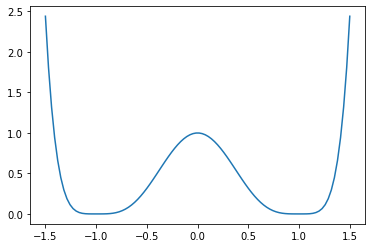

In [3]:
def potential(x):
    return (x - 1) ** 4 * (x + 1) ** 4

xs = np.linspace(-1.5, 1.5, num=100) # We will sample 100 discrete bins
plt.plot(xs, potential(xs));

We will use umbrella sampling to sample the potential. Define a sampling axis and the umbrella centers. These umbrella centers define our thermodynamic states.

In [4]:
bias_centers = np.linspace(-1.5, 1.5, 20) # 20 umbrella's

# we use a harmonic bias potential
def harmonic(x0, x):
    return 2 * (x - x0) ** 4

For each of the bias centers, contruct the bias potential as a sum of the original potential and the harmonic bias.

In [5]:
biased_potentials = []
for bias_center in bias_centers:
    bias = lambda x, x0=bias_center: harmonic(x0, x) + potential(x)
    biased_potentials.append(bias)

Now we will sample a discrete trajectory for each of the thermodynamic states. We use a deeptime MSM to perform the sampling.

In [6]:
n_samples = 10000  # trajectory length

trajectories = np.zeros((len(bias_centers), n_samples), dtype=np.int32)

for i, U in enumerate(biased_potentials):
    biased_energies = U(xs)  # get the potential at each of the bins

    transition_matrix = tmatrix_metropolis1d(biased_energies)

    msm = MarkovStateModel(transition_matrix)
    trajectories[i] = msm.simulate(n_steps=n_samples)

Plot the sampled trajectories and biased potentials:

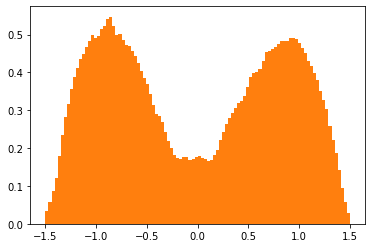

In [7]:
plt.hist(xs[trajectories.flatten()], bins=100, density=True, color='C1',
         label='Histogram over visited states');

Now use the deeptime KMeans module to cluster the data into 2 states (using the knowledge that we are working with a double-well potential). For each sample, the Markov state that sample was in is stored in `dtrajs`.

In [8]:
estimator = KMeans(
        n_clusters=2,  # place 2 cluster centers
        init_strategy='uniform',  # uniform initialization strategy
        max_iter=10,
        fixed_seed=13,
        n_jobs=8
    )

clustering = estimator.fit_fetch(trajectories.flatten())
dtrajs = clustering.transform(trajectories.flatten()).reshape(
        (len(trajectories), n_samples))

print(clustering.cluster_centers)

[[75.06651925]
 [23.44896068]]


The final piece of input we need are the bias matrices, $K$ matrices, one for each thermodynamic state. 

The bias matrix of thermodynamic state $k$ is of shape $(N_k, K)$, $N_k$ being the number of samples taken at state $k$. `bias_matrices[k, i, l]` is the potential of the $i$-th sample taken at state $k$, **evaluated at** state $l$. 

In symbols, when $x_i^k$ is the $i$'th sample taken at thermodynamic state $k$, `bias_matrices[k, i, l]` $= b^l(x_i^k)$.

This means that for each sample taken __at any given state__, the bias potentials of that sample __in all states__ need to be stored!

In [9]:
# move the range of the trajectories back to the range of xs: (-1.5, 1.5)
trajectories_shifted = trajectories / 100 * 3 - 1.5

bias_matrices = np.zeros((len(bias_centers), n_samples, len(bias_centers)))
for i, traj in enumerate(trajectories_shifted):  # enumerate the states (=trajectories)
    for j, bias_function in enumerate(biased_potentials):  # for each term. state...
        # ... store the bias potential of all samples as if they were sampled at that thermodynamic state
        bias_matrices[i, :, j] = bias_function(traj) - potential(traj) 

Construct a `TRAMDataset` object from the discrete trajectories and the bias matrices. This object will construct the state and transition count matrices.

In [14]:
dataset = TRAMDataset(dtrajs=dtrajs, bias_matrices=bias_matrices)
bias_matrices.shape
dtrajs.shape

(20, 10000)

We can use the dataset to reduce our data to a chosen submodel, or to the largest connected set according to chosen criteria. One could also choose to reduce the data to a chosen submodel, for example if one wants to compute the connected set by a different method than the ones available in the TRAM module. In this case, we want to reduce our dataset to the largest connected set by the BAR variance connectivity criterium. This may take a while, so we pass a progress bar to show the progress.

In [18]:
from tqdm.notebook import tqdm
dataset.restrict_to_largest_connected_set(connectivity='BAR_variance', progress=tqdm)
dataset.dtrajs

  0%|          | 0/40 [00:00<?, ?it/s]

[array([1, 1, 1, ..., 1, 1, 1]),
 array([1, 1, 1, ..., 1, 1, 1]),
 array([1, 1, 1, ..., 1, 1, 1]),
 array([1, 1, 1, ..., 1, 1, 1]),
 array([1, 1, 1, ..., 1, 1, 1]),
 array([1, 1, 1, ..., 1, 1, 1]),
 array([1, 1, 1, ..., 1, 1, 1]),
 array([0, 0, 0, ..., 1, 1, 1]),
 array([1, 1, 1, ..., 1, 1, 1]),
 array([0, 0, 0, ..., 1, 1, 1]),
 array([1, 1, 1, ..., 0, 0, 0]),
 array([1, 1, 1, ..., 1, 1, 1]),
 array([0, 0, 0, ..., 0, 0, 0]),
 array([0, 0, 0, ..., 0, 0, 0]),
 array([0, 0, 0, ..., 0, 0, 0]),
 array([0, 0, 0, ..., 0, 0, 0]),
 array([0, 0, 0, ..., 0, 0, 0]),
 array([0, 0, 0, ..., 0, 0, 0]),
 array([0, 0, 0, ..., 0, 0, 0]),
 array([0, 0, 0, ..., 0, 0, 0])]

Now we have gathered all our input, we can run a TRAM estimate. Because we set maxiter to 100, this might give us a warning that TRAM did not converge (100 iterations is enough for demonstration purposes). The model we obtain contains the data from the connected set.

In [15]:
tram = TRAM(lagtime=50, maxiter=100, progress=tqdm, callback_interval=3, init_strategy=None)
model = tram.fit_fetch((dtrajs, bias_matrices))

  0%|          | 0/100 [00:00<?, ?it/s]

ValueError: Got 2 transition matrices but 2 stationary distributions and 20 count models. For a one-to-one correspondence, these must match.

We can plot the `biased_conf_energies` in a contour plot to see what they look like.

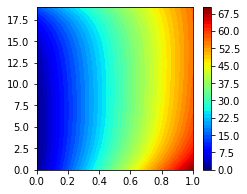

In [25]:
fig, (ax1) = plt.subplots(1, figsize=(3.5, 3))
im = ax1.contourf(model._biased_conf_energies, levels=50, cmap='jet')
plt.colorbar(im);

## Recovering the PMF

Now we want to recover the potential function (PMF). To do this, we define a number of bins (in this case 25) that we want to calculate the unbiased PMF over. We discretize all samples into these 25 bins, and use the model to calculate the PMF over the bins.

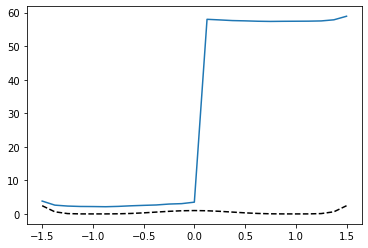

In [26]:
n_bins = 25
bins = np.linspace(-1.5, 1.5, n_bins)

# the bin number for each sample. Samples are binned into 25 bins
bin_numbers = np.floor(trajectories/(100/n_bins)).astype(np.int32)

# pass samples to the model with their corresponding bin numbers
pmf = model.compute_PMF(dtrajs, bias_matrices, bin_numbers)
plt.plot(bins, pmf)

# compare with the original distribution, shifted so that the minimum lies at zero.
plt.plot(bins, potential(bins) - potential(bins).min(), 'k--');